# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from gap_statistic import OptimalK
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
df_attribute = pd.read_excel("DIAS Attributes - Values 2017.xlsx",usecols='B:E', skiprows = 1)

In [3]:
# load in the data
df_AZDIAS = pd.read_csv('Udacity_AZDIAS_052018.csv',low_memory=False)
df_CUSTOMERS = pd.read_csv("Udacity_CUSTOMERS_052018.csv",low_memory=False)

In [4]:
df_AZDIAS.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
df_attribute.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [6]:
df_CUSTOMERS.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
# Find attribute (columns of df_AZDIAS) which can find description in "DIAS Attributes - Values 2017" excel file
attribute = df_attribute[df_attribute["Attribute"].notna()]["Attribute"].unique()

common_AZDIAS_Attribute = set(df_AZDIAS.columns.tolist()).intersection(set(attribute.tolist()))
print("Number of columns of AZDIAS dataset which can find description in DIAS Attributes: " + str(len(common_AZDIAS_Attribute)))

commom_customers_attribute = set(df_CUSTOMERS.columns.tolist()).intersection(set(attribute.tolist()))
print("Number of columns of CUSTOMERS dataset which can find description in DIAS Attributes: " + str(len(commom_customers_attribute)))

Number of columns of AZDIAS dataset which can find description in DIAS Attributes: 272
Number of columns of CUSTOMERS dataset which can find description in DIAS Attributes: 272


In [8]:
# Remove columns which cannot find description in "DIAS Attributes - Values 2017" excel file 
df_AZDIAS_clean = df_AZDIAS[list(common_AZDIAS_Attribute)]
df_CUSTOMERS_clean = df_CUSTOMERS[list(commom_customers_attribute)]

In [9]:
df_attribute["Attribute"] = df_attribute["Attribute"].fillna(method='ffill')
df_attribute_clean = df_attribute[df_attribute["Attribute"].isin(list(common_AZDIAS_Attribute))]

In [10]:
# Filter value which has unknown meaning 
df_attribute_unknown = df_attribute_clean[df_attribute_clean['Meaning'].str.lower().str.contains('no |unknown', na=False)]
df_attribute_unknown

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [11]:
# Consolidate all unknown value for each attribute 
grouped = df_attribute_unknown.groupby('Attribute')['Value'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
grouped

,Attribute,Value
0,AGER_TYP,"-1, 0"
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ALTER_HH,0
3,ANREDE_KZ,"-1, 0"
4,BALLRAUM,-1
...,...,...
245,VERS_TYP,-1
246,WOHNDAUER_2008,"-1, 0"
247,WOHNLAGE,"-1, 0"
248,W_KEIT_KIND_HH,"-1, 0"


In [12]:
# Replace unknown value with NA
for i in range(0, 250):
    key = grouped.iloc[i]["Attribute"]
    value = [int(num) for num in grouped.iloc[i]["Value"].split(',')]
    df_AZDIAS_clean[key] = df_AZDIAS_clean[key].replace(value, np.nan)

<ipython-input-12-685837eb59d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AZDIAS_clean[key] = df_AZDIAS_clean[key].replace(value, np.nan)


In [13]:
# Calculate the number of missing values in each column of df_AZDIAS_clean
missing_values_count = df_AZDIAS_clean.isna().sum()

# Calculate the percentage of missing values in each column of df_AZDIAS_clean
missing_values_percentage = (missing_values_count / df_AZDIAS_clean.shape[0]) * 100

# Create a DataFrame to display count and percentage of missing values
missing_values_df_AZDIAS = pd.DataFrame({
    'missing_values_count': missing_values_count,
    'missing_values_percentage': missing_values_percentage
})


Text(0.5, 1.0, 'Distribution of Missing Values Percentage for AZDIAS dataset')

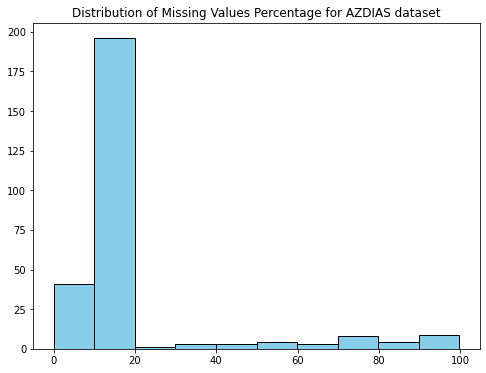

In [14]:
# Plotting
plt.figure(figsize=(8, 6))

# Histogram for the distribution of missing values percentage
plt.hist(missing_values_percentage, bins=10, color='skyblue', edgecolor='black')

plt.title('Distribution of Missing Values Percentage for AZDIAS dataset')

In [15]:
# Most of columns has missing value less than 20% based on the chart
columns_with_many_missing_value_AZDIAS = missing_values_df_AZDIAS[missing_values_df_AZDIAS["missing_values_percentage"] > 20].index.tolist()

print("Remove number of columns: ", str(len(columns_with_many_missing_value_AZDIAS)))

Remove number of columns:  35


In [16]:
# remove those columns with missing value more than 20% 
df_AZDIAS_exc_missing_col = df_AZDIAS_clean.drop(columns = columns_with_many_missing_value_AZDIAS, axis = 1)
df_AZDIAS_exc_missing_col

,KBA05_HERST1,KBA05_SEG9,PRAEGENDE_JUGENDJAHRE,KBA13_KW_121,ANZ_PERSONEN,KBA13_HALTER_25,KBA13_BJ_2004,MIN_GEBAEUDEJAHR,ALTERSKATEGORIE_GROB,KBA13_KRSSEG_VAN,...,KBA13_HALTER_65,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA13_VORB_0,KBA05_HERST3,KBA13_SEG_WOHNMOBILE,KBA05_SEG6,KBA13_SEG_OBEREMITTELKLASSE,KBA13_BJ_2006,KBA05_MAXSEG
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,0.0,14.0,3.0,2.0,3.0,3.0,1992.0,1,2.0,...,3.0,8.0,8A,3.0,2.0,2.0,1.0,3.0,3.0,4.0
2,2.0,1.0,15.0,4.0,1.0,3.0,4.0,1992.0,3,2.0,...,4.0,4.0,4C,3.0,3.0,2.0,0.0,4.0,5.0,1.0
3,4.0,1.0,8.0,5.0,0.0,2.0,3.0,1997.0,4,2.0,...,3.0,2.0,2A,4.0,3.0,2.0,0.0,3.0,3.0,2.0
4,2.0,2.0,8.0,5.0,4.0,3.0,3.0,1992.0,3,1.0,...,3.0,6.0,6B,4.0,4.0,5.0,0.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2.0,14.0,1.0,1.0,3.0,4.0,1992.0,3,2.0,...,4.0,7.0,7A,3.0,3.0,3.0,0.0,2.0,4.0,3.0
891217,3.0,0.0,10.0,2.0,1.0,5.0,3.0,1992.0,2,1.0,...,4.0,9.0,9D,2.0,1.0,5.0,0.0,5.0,2.0,2.0
891218,4.0,1.0,14.0,3.0,0.0,4.0,2.0,1992.0,2,3.0,...,2.0,4.0,4C,4.0,3.0,1.0,0.0,3.0,2.0,2.0
891219,2.0,0.0,14.0,1.0,1.0,3.0,3.0,1992.0,1,1.0,...,3.0,9.0,9D,1.0,4.0,3.0,0.0,3.0,1.0,2.0


In [17]:
#replace unknown value with NA value
for i in range(0, 250):
    key = grouped.iloc[i]["Attribute"]
    value = [int(num) for num in grouped.iloc[i]["Value"].split(',')]
    df_CUSTOMERS_clean[key] = df_CUSTOMERS_clean[key].replace(value, np.nan)

<ipython-input-17-b953caecaf50>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CUSTOMERS_clean[key] = df_CUSTOMERS_clean[key].replace(value, np.nan)


Text(0.5, 1.0, 'Distribution of Missing Values Percentage for CUSTOMERS dataset')

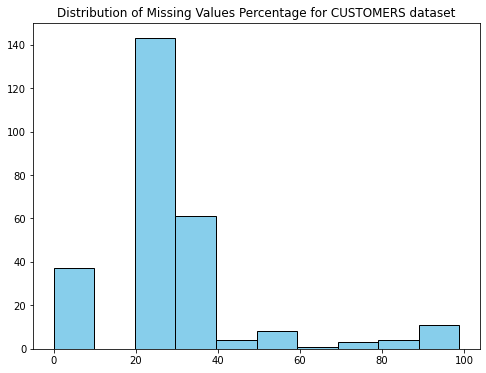

In [18]:
# Calculate the number of missing values in each column of df_CUSTOMERS_clean
missing_values_count = df_CUSTOMERS_clean.isna().sum()

# Calculate the percentage of missing values in each column of df_CUSTOMERS_clean
missing_values_percentage = (missing_values_count / df_CUSTOMERS_clean.shape[0]) * 100

# Create a DataFrame to display count and percentage of missing values
missing_values_df_customers = pd.DataFrame({
    'missing_values_count': missing_values_count,
    'missing_values_percentage': missing_values_percentage
})

# Plotting
plt.figure(figsize=(8, 6))

# Histogram for the distribution of missing values percentage
plt.hist(missing_values_percentage, bins=10, color='skyblue', edgecolor='black')

plt.title('Distribution of Missing Values Percentage for CUSTOMERS dataset')

In [19]:
# Most of columns have missing value less than 40%
columns_with_many_missing_customers = missing_values_df_customers[missing_values_df_customers["missing_values_percentage"] > 40].index.tolist()

In [20]:
# remove columns with more than 40% percentage of missing value
df_CUSTOMERS_excl_missing_col = df_CUSTOMERS_clean.drop(columns = columns_with_many_missing_customers, axis = 1)
df_CUSTOMERS_excl_missing_col

,KBA05_HERST1,KBA05_SEG9,PRAEGENDE_JUGENDJAHRE,KBA13_KW_121,ANZ_PERSONEN,KBA13_HALTER_25,KBA13_BJ_2004,MIN_GEBAEUDEJAHR,ALTERSKATEGORIE_GROB,KBA13_KRSSEG_VAN,...,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA13_VORB_0,KBA05_HERST3,KBA13_SEG_WOHNMOBILE,KBA05_SEG6,D19_GESAMT_DATUM,KBA13_SEG_OBEREMITTELKLASSE,KBA13_BJ_2006,KBA05_MAXSEG
0,4.0,2.0,4.0,3.0,2.0,1.0,3.0,1992.0,4,2.0,...,1.0,1A,4.0,3.0,4.0,1.0,9.0,4.0,3.0,3.0
1,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN
2,4.0,1.0,4.0,3.0,1.0,3.0,1.0,1992.0,4,1.0,...,5.0,5D,4.0,1.0,5.0,0.0,NaN,2.0,2.0,2.0
3,3.0,0.0,1.0,3.0,0.0,4.0,3.0,1992.0,4,3.0,...,4.0,4C,4.0,3.0,2.0,0.0,6.0,2.0,4.0,1.0
4,1.0,0.0,8.0,3.0,4.0,2.0,3.0,1992.0,3,2.0,...,7.0,7B,3.0,3.0,3.0,0.0,1.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,5.0,2.0,4.0,5.0,1.0,2.0,1.0,1992.0,3,2.0,...,1,1C,5.0,0.0,3.0,1.0,7.0,4.0,2.0,4.0
191648,2.0,1.0,5.0,3.0,0.0,3.0,4.0,1997.0,4,2.0,...,5,5B,3.0,5.0,3.0,0.0,9.0,4.0,3.0,2.0
191649,2.0,1.0,4.0,3.0,3.0,3.0,3.0,1992.0,4,2.0,...,4,4D,3.0,4.0,5.0,0.0,8.0,3.0,3.0,3.0
191650,1.0,0.0,8.0,0.0,4.0,3.0,4.0,1992.0,3,1.0,...,4,4C,2.0,3.0,2.0,0.0,5.0,5.0,3.0,1.0


In [21]:
string_columns_AZDIAS = df_AZDIAS_exc_missing_col.select_dtypes(include=['object']).columns
string_columns_AZDIAS

Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype='object')

In [22]:
string_columns_CUSTOMERS = df_CUSTOMERS_excl_missing_col.select_dtypes(include=['object']).columns
string_columns_CUSTOMERS

Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype='object')

In [23]:
# make sure the object column has all string format value
df_AZDIAS_exc_missing_col['CAMEO_DEUG_2015'] = df_AZDIAS_exc_missing_col['CAMEO_DEUG_2015'].astype(str)
df_AZDIAS_exc_missing_col["OST_WEST_KZ"] = df_AZDIAS_exc_missing_col["OST_WEST_KZ"].astype(str)
df_AZDIAS_exc_missing_col["CAMEO_DEU_2015"] = df_AZDIAS_exc_missing_col["CAMEO_DEU_2015"].astype(str)

df_CUSTOMERS_excl_missing_col['CAMEO_DEUG_2015'] = df_CUSTOMERS_excl_missing_col['CAMEO_DEUG_2015'].astype(str)
df_CUSTOMERS_excl_missing_col["OST_WEST_KZ"] = df_CUSTOMERS_excl_missing_col["OST_WEST_KZ"].astype(str)
df_CUSTOMERS_excl_missing_col["CAMEO_DEU_2015"] = df_CUSTOMERS_excl_missing_col["CAMEO_DEU_2015"].astype(str)

In [24]:
label_encoder = LabelEncoder()

# Using label encoding to transform categorical variable into numeric format 
df_AZDIAS_exc_missing_col['CAMEO_DEUG_2015'] = label_encoder.fit_transform(df_AZDIAS_exc_missing_col['CAMEO_DEUG_2015'])
df_AZDIAS_exc_missing_col["OST_WEST_KZ"] = label_encoder.fit_transform(df_AZDIAS_exc_missing_col["OST_WEST_KZ"])
df_AZDIAS_exc_missing_col["CAMEO_DEU_2015"] = label_encoder.fit_transform(df_AZDIAS_exc_missing_col["CAMEO_DEU_2015"])

df_CUSTOMERS_excl_missing_col['CAMEO_DEUG_2015'] = label_encoder.fit_transform(df_CUSTOMERS_excl_missing_col['CAMEO_DEUG_2015'])
df_CUSTOMERS_excl_missing_col["OST_WEST_KZ"] = label_encoder.fit_transform(df_CUSTOMERS_excl_missing_col["OST_WEST_KZ"])
df_CUSTOMERS_excl_missing_col["CAMEO_DEU_2015"] = label_encoder.fit_transform(df_CUSTOMERS_excl_missing_col["CAMEO_DEU_2015"])

In [25]:
df_AZDIAS_final = df_AZDIAS_exc_missing_col
df_CUSTOMERS_final = df_CUSTOMERS_excl_missing_col

In [26]:
# Find out common columns between df_AZDIAS_final and df_CUSTOMERS_final
AZDIAS_final_columns = df_AZDIAS_final.columns.tolist()
CUSTOMERS_final_columns = df_CUSTOMERS_final.columns.tolist()
common_final_AZDIAS_CUSTOMERS = set(AZDIAS_final_columns).intersection(set(CUSTOMERS_final_columns))
len(common_final_AZDIAS_CUSTOMERS)

237

In [27]:
final_common_columns = [item for item in common_final_AZDIAS_CUSTOMERS]
df_AZDIAS_final = df_AZDIAS_final[final_common_columns]
df_CUSTOMERS_final = df_CUSTOMERS_final[final_common_columns]

In [28]:
df_AZDIAS_final.dtypes.value_counts()

float64    208
int64       29
dtype: int64

In [29]:
df_CUSTOMERS_final.dtypes.value_counts()

float64    208
int64       29
dtype: int64

In [30]:
#impute missing value for df_AZDIAS_final
AZDIAS_column = df_AZDIAS_final.columns.tolist()

for col in AZDIAS_column:
    df_AZDIAS_final[col] = df_AZDIAS_final[col].fillna(method='ffill')
    df_AZDIAS_final[col].fillna(df_AZDIAS_final[col].mode()[0], inplace=True)       

In [ ]:
#impute missing value for df_CUSTOMERS_final

Customers_column = df_CUSTOMERS_final.columns.tolist()

for col in Customers_column: 
    df_CUSTOMERS_final[col] = df_CUSTOMERS_final[col].fillna(method='ffill')
    df_CUSTOMERS_final[col].fillna(df_CUSTOMERS_final[col].mode()[0], inplace=True)   

In [32]:
# Check if df_AZDIAS_final has all NA value filled
has_na = df_AZDIAS_final.isna().any().any()
has_na

False

In [33]:
# Check if df_CUSTOMERS_final has all NA value filled
has_na = df_CUSTOMERS_final.isna().any().any()
has_na

False

### Principal Component Analysis

In [34]:
# Scale the data
CUSTOMERS_scale = StandardScaler().fit_transform(df_CUSTOMERS_final)
AZDIAS_scale = StandardScaler().fit_transform(df_AZDIAS_final)

In [35]:
pca = PCA()
pca.fit(CUSTOMERS_scale)

PCA()

In [36]:
# Calculate cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()


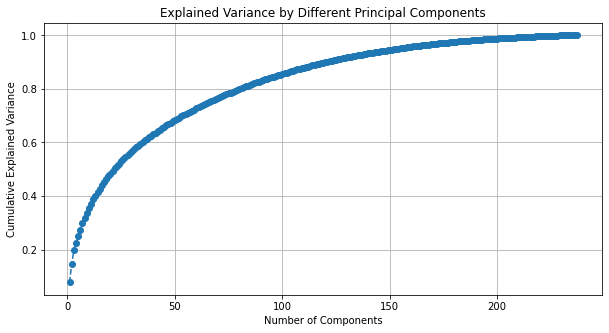

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Different Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True) 
plt.show()

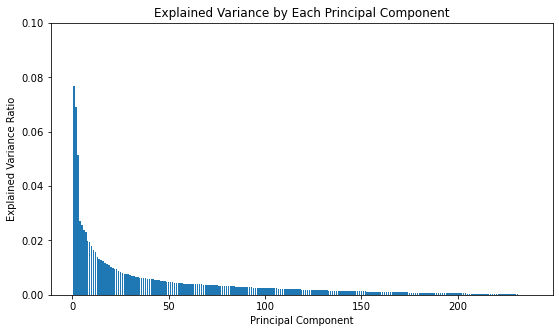

In [38]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(9, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.ylim(0, 0.1)
plt.show()


In [39]:
# Create a pandas DataFrame from the components of PCA 
Customers_components = pd.DataFrame(pca.components_)
Customers_components.columns = df_CUSTOMERS_final.columns.tolist()
Customers_components

,KBA05_HERST1,KBA05_SEG9,PRAEGENDE_JUGENDJAHRE,KBA13_KW_121,ANZ_PERSONEN,KBA13_HALTER_25,KBA13_BJ_2004,MIN_GEBAEUDEJAHR,ALTERSKATEGORIE_GROB,KBA13_KRSSEG_VAN,...,KBA13_HALTER_65,CAMEO_DEUG_2015,CAMEO_DEU_2015,KBA13_VORB_0,KBA05_HERST3,KBA13_SEG_WOHNMOBILE,KBA05_SEG6,KBA13_SEG_OBEREMITTELKLASSE,KBA13_BJ_2006,KBA05_MAXSEG
0,1.249215e-01,-1.079279e-02,-1.424415e-02,1.352717e-01,-1.671613e-02,-9.241364e-02,-1.540802e-02,-2.526250e-02,-8.727709e-04,-2.113714e-02,...,1.018828e-01,-1.414060e-02,-1.110553e-02,1.039108e-01,-8.895361e-02,2.559929e-02,6.642971e-02,1.470866e-01,1.665604e-02,8.616018e-02
1,-3.321795e-02,-4.558108e-02,4.648253e-03,-2.127459e-02,-7.221173e-02,1.664861e-02,-1.276066e-02,-1.426412e-02,-1.174367e-01,-4.275860e-02,...,-5.683744e-04,1.782882e-01,1.804218e-01,-2.338311e-02,3.314507e-03,-1.082779e-02,-2.726354e-02,-1.902346e-03,-2.588397e-02,-2.155666e-02
2,-2.648348e-02,-4.447431e-02,-5.382337e-02,-3.115831e-02,-2.361493e-02,2.114827e-02,-1.062718e-02,-3.580831e-02,1.738230e-01,-4.552544e-02,...,3.988533e-03,-1.129159e-01,-1.028152e-01,-1.119226e-02,7.864470e-03,-1.837573e-02,-2.088312e-02,-1.143145e-02,-2.031961e-02,-2.217612e-02
3,-1.229150e-01,-1.040751e-02,-1.235413e-02,1.808580e-02,-1.774245e-02,8.425362e-02,3.045022e-02,7.426229e-03,5.290104e-04,5.325279e-02,...,-2.676063e-02,-8.829364e-03,-7.411788e-03,2.031266e-01,5.762475e-02,-7.268194e-02,-5.295972e-02,-2.897288e-02,1.078670e-01,-1.405098e-01
4,1.177992e-02,-3.213176e-02,-3.633659e-03,4.016076e-02,-1.095354e-02,1.382143e-01,-6.167461e-03,6.239063e-03,3.848222e-02,-2.005671e-02,...,-1.886242e-01,7.259860e-03,7.084150e-03,-1.902734e-02,-1.467032e-02,-4.743506e-02,-1.643341e-02,9.865025e-03,-6.927536e-03,8.800701e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,5.405362e-04,-7.118121e-04,-6.360194e-03,2.190235e-04,1.389498e-02,-1.017625e-03,-2.019730e-05,1.061119e-03,4.122745e-03,3.493998e-04,...,-2.460728e-04,-1.439733e-02,3.081000e-03,-2.054289e-03,-9.533480e-04,2.305217e-05,2.925264e-04,-8.160809e-04,3.478931e-04,-3.156266e-04
233,-2.761004e-04,-8.920475e-04,-7.161353e-03,3.445053e-05,2.231133e-03,1.042374e-03,-5.166594e-04,-2.817542e-03,-2.448303e-03,-4.072209e-05,...,1.431221e-04,1.406681e-02,-5.376026e-03,5.150682e-04,-1.447815e-03,-2.768708e-04,1.386562e-04,-2.210291e-04,-2.848008e-04,-8.012903e-04
234,4.892272e-05,8.992899e-04,-2.183000e-04,-1.510187e-04,-6.285754e-04,1.329010e-04,-6.955932e-04,-2.438349e-03,-1.120423e-03,2.771862e-04,...,9.389538e-04,7.188664e-01,-6.937687e-01,5.172841e-04,9.688208e-04,1.061951e-03,2.656105e-04,1.601145e-03,-5.145626e-04,6.062327e-04
235,-5.411823e-04,-1.169897e-04,-5.120351e-03,-4.768299e-04,8.561658e-03,2.641847e-04,-4.629877e-04,6.343007e-04,9.690500e-04,2.006652e-04,...,1.366444e-04,1.697452e-02,-1.674540e-02,3.657505e-04,-1.154225e-04,6.735085e-05,7.140893e-05,-2.736201e-04,1.948863e-04,3.139794e-04


In [45]:
df_attribute_nonNA = df_attribute[df_attribute["Description"].notna()]
Attribute_check = df_attribute_nonNA[["Attribute", "Description"]]
Attribute_check.index = range(1, len(Attribute_check) + 1)

#### Component1

In [47]:
pd.set_option('display.max_colwidth', None)

In [48]:
Customers_component1 = Customers_components.iloc[0].sort_values(ascending=False)
Customers_component1_head = Customers_component1[:5].index.tolist()
Attribute_check[Attribute_check["Attribute"].isin(Customers_component1_head)]

,Attribute,Description
239,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8
248,KBA13_KMH_211,share of cars with a greater max speed than 210 km/h within the PLZ8
249,KBA13_KMH_250,share of cars with max speed between 210 and 250 km/h within the PLZ8
272,KBA13_MERCEDES,share of MERCEDES within the PLZ8
286,KBA13_SEG_OBEREMITTELKLASSE,"share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)"


In [49]:
Customers_component1_tail = Customers_component1[-5:].index.tolist()
Attribute_check[Attribute_check["Attribute"].isin(Customers_component1_tail)]

,Attribute,Description
241,KBA13_HERST_FORD_OPEL,share of Ford & Opel/Vauxhall within the PLZ8
245,KBA13_KMH_180,share of cars with max speed between 110 km/h and 180km/h within the PLZ8
247,KBA13_KMH_140_210,share of cars with max speed between 140 and 210 km/h within the PLZ8
263,KBA13_KW_0_60,share of cars up to 60 KW engine power - PLZ8
281,KBA13_SEG_KLEINWAGEN,"share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8"


#### Component2

In [50]:
Customers_component2 = Customers_components.iloc[1].sort_values(ascending=False)
Customers_component2_head = Customers_component2[:5].index.tolist()
Attribute_check[Attribute_check["Attribute"].isin(Customers_component2_head)]

,Attribute,Description
11,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup
12,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification
116,FINANZ_SPARER,financial typology: money saver
332,SEMIO_KAEM,affinity indicating in what way the person is of a fightfull attitude
333,SEMIO_KRIT,affinity indicating in what way the person is critical minded


In [51]:
Customers_component2_tail = Customers_component2[-5:].index.tolist()
Attribute_check[Attribute_check["Attribute"].isin(Customers_component2_tail)]

,Attribute,Description
115,FINANZ_MINIMALIST,financial typology: low financial interest
307,LP_LEBENSPHASE_FEIN,lifestage fine
308,LP_LEBENSPHASE_GROB,lifestage rough
309,LP_STATUS_FEIN,social status fine
310,LP_STATUS_GROB,social status rough


#### Component3

In [52]:
Customers_component3 = Customers_components.iloc[2].sort_values(ascending=False)
Customers_component3_head = Customers_component3[:5].index.tolist()
Attribute_check[Attribute_check["Attribute"].isin(Customers_component3_head)]

,Attribute,Description
2,ALTERSKATEGORIE_GROB,age classification through prename analysis
118,FINANZ_VORSORGER,financial typology: be prepared
128,HH_EINKOMMEN_SCORE,estimated household net income
340,SEMIO_SOZ,affinity indicating in what way the person is social minded
342,SEMIO_VERT,affinity indicating in what way the person is dreamily


In [53]:
Customers_component3_tail = Customers_component3[-5:].index.tolist()
Attribute_check[Attribute_check["Attribute"].isin(Customers_component3_tail)]

,Attribute,Description
113,FINANZ_ANLEGER,financial typology: investor
116,FINANZ_SPARER,financial typology: money saver
117,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable
317,OST_WEST_KZ,flag indicating the former GDR/FRG
339,SEMIO_REL,affinity indicating in what way the person is religious


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [54]:
# 100 pca components can explain most of the variance, so set n_components=100
pca = PCA(n_components=100)
CUSTOMER_pca = pca.fit_transform(CUSTOMERS_scale)

In [55]:
AZDIAS_pca = pca.transform(AZDIAS_scale)

In [56]:
# Finding the optimal number of clusters using inertia (sum of squared distances to the nearest cluster center)
inertia = []
for k in range(2, 10):  # You can change the range as needed
    kmeans = KMeans(n_clusters=k,n_init= 2, random_state=0)
    kmeans.fit(CUSTOMER_pca)
    inertia.append(kmeans.inertia_)

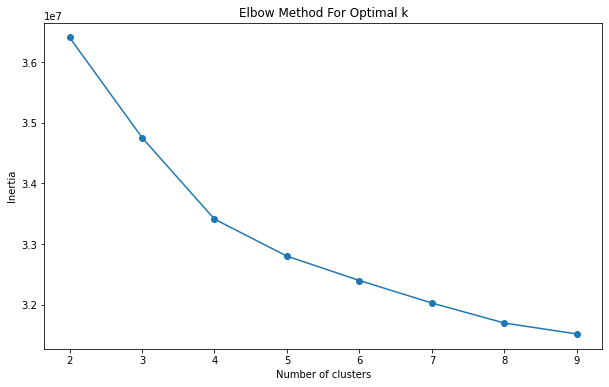

In [57]:
# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [58]:
optimalK = OptimalK(parallel_backend='joblib')

# Calculating the optimal number of clusters
n_clusters = optimalK(CUSTOMER_pca, cluster_array=np.arange(2, 10))

print('Optimal number of clusters:', n_clusters)

Optimal number of clusters: 9


In [59]:
k_optimal = 9
kmeans = KMeans(n_clusters=k_optimal,n_init = 2, random_state=0)
clusters = kmeans.fit_predict(CUSTOMER_pca)
clusters_AZDIAS = kmeans.fit_predict(AZDIAS_pca)

In [60]:
CUSTOMER_cluster = pd.DataFrame(clusters, columns = ["cluster"])
AZDIAS_cluster = pd.DataFrame(clusters_AZDIAS, columns = ["cluster"])

In [61]:
CUSTOMER_cluster_group = CUSTOMER_cluster['cluster'].value_counts().reset_index()
CUSTOMER_cluster_group.columns = ['cluster', 'count']

# Calculate the percentage of each cluster
CUSTOMER_cluster_group['CUSTOMER_percentage'] = (CUSTOMER_cluster_group['count'] / CUSTOMER_cluster_group['count'].sum()) * 100

In [62]:
CUSTOMER_cluster_group = CUSTOMER_cluster_group.sort_values(by='cluster', ascending=True)
CUSTOMER_cluster_group

,cluster,count,CUSTOMER_percentage
8,0,10944,5.710350
3,1,25238,13.168660
1,2,28837,15.046543
4,3,20140,10.508630
6,4,17706,9.238620
5,5,18114,9.451506
0,6,28982,15.122201
2,7,26145,13.641913
7,8,15546,8.111577


In [63]:
AZDIAS_cluster_group = AZDIAS_cluster['cluster'].value_counts().reset_index()
AZDIAS_cluster_group.columns = ['cluster', 'count']

# Calculate the percentage of each cluster
AZDIAS_cluster_group['AZDIAS_percentage'] = (AZDIAS_cluster_group['count'] / AZDIAS_cluster_group['count'].sum()) * 100

In [64]:
AZDIAS_cluster_group = AZDIAS_cluster_group.sort_values(by='cluster', ascending=True)
AZDIAS_cluster_group

,cluster,count,AZDIAS_percentage
6,0,68864,7.726927
0,1,141040,15.825480
7,2,68489,7.684850
1,3,127747,14.333931
8,4,66821,7.497691
4,5,95215,10.683658
3,6,112725,12.648378
2,7,120013,13.466132
5,8,90307,10.132952


In [65]:
# Compare clusters between the general population of Grmany and customers of a mail-order company
cluster_compare = pd.merge(AZDIAS_cluster_group, CUSTOMER_cluster_group, on='cluster', how='left')
cluster_compare_clean = cluster_compare.drop(columns = ["count_x","count_y"])
cluster_compare_clean

,cluster,AZDIAS_percentage,CUSTOMER_percentage
0,0,7.726927,5.710350
1,1,15.825480,13.168660
2,2,7.684850,15.046543
3,3,14.333931,10.508630
4,4,7.497691,9.238620
5,5,10.683658,9.451506
6,6,12.648378,15.122201
7,7,13.466132,13.641913
8,8,10.132952,8.111577


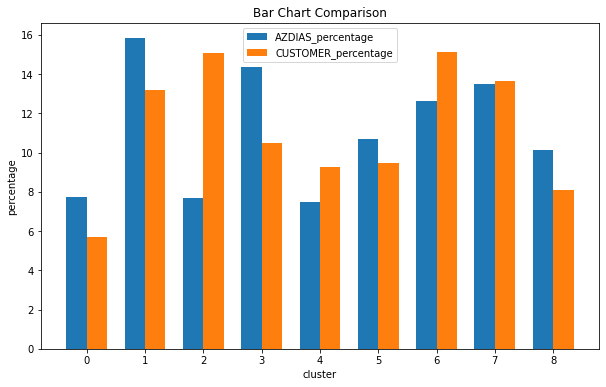

In [66]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting two sets of bars
width = 0.35  # Width of the bars
x = cluster_compare_clean['cluster']  # Categories

# Position of bars on x-axis

ind = np.arange(len(x))

plt.bar(ind - width/2, cluster_compare_clean['AZDIAS_percentage'], width, label='AZDIAS_percentage')
plt.bar(ind + width/2, cluster_compare_clean['CUSTOMER_percentage'], width, label='CUSTOMER_percentage')

# Adding labels
plt.xlabel('cluster')
plt.ylabel('percentage')
plt.title('Bar Chart Comparison')

# Adding x-tick labels
plt.xticks(ind, x)

# Adding legend
plt.legend()

# Display the plot
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [67]:
mailout_train = pd.read_csv('mailout_train.csv',low_memory=False)


In [68]:
mailout_train.shape

(42962, 368)

In [69]:
mailout_train["RESPONSE"].unique()

array([0, 1])

In [72]:
mailout_test = pd.read_csv('mailout_test.csv',low_memory=False)

In [73]:
mailout_test.shape

(42833, 367)

In [74]:
# Define function to replace unknown value with NA in dataset
def replace_unknown(data_set):
    
    common_mailout_Attribute = set(mailout_train.columns.tolist()).intersection(set(df_attribute["Attribute"].tolist()))
    df_attribute_mailout = df_attribute[df_attribute["Attribute"].isin(list(common_mailout_Attribute))]
    df_attribute_mailout_unknown = df_attribute_mailout[df_attribute_mailout['Meaning'].str.lower().str.contains('no |unknown', na=False)]
    grouped_mailout = df_attribute_mailout_unknown.groupby('Attribute')['Value'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
    
    for i in range(0, len(grouped_mailout)):
        key = grouped_mailout.iloc[i]["Attribute"]
        value = [int(num) for num in grouped_mailout.iloc[i]["Value"].split(',')]
        data_set[key] = data_set[key].replace(value, np.nan)

In [75]:
# Replace unknown value with NA in mailout_train
replace_unknown(mailout_train)

In [76]:
# Replace unknown value with NA in mailout_test
replace_unknown(mailout_test)

In [77]:
# Filter columns with object data type
mailout_train_object_column = mailout_train.select_dtypes(include=['object']).columns.tolist()
mailout_test_object_column = mailout_test.select_dtypes(include=['object']).columns.tolist()

print(mailout_train_object_column)
print(mailout_test_object_column)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']
['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


In [78]:
label_encoder = LabelEncoder()

# Using label encoding to transform categorical variable into numeric format 
def transform_encode(dataframe, column):
    dataframe[column] = dataframe[column].astype(str)
    dataframe[column] = label_encoder.fit_transform(dataframe[column])

for col in mailout_train_object_column:
    transform_encode(mailout_train, col)
    
for col in mailout_test_object_column:
    transform_encode(mailout_test, col)

In [79]:
def missing_value_check(dataframe):
    
    missing_values_count = dataframe.isna().sum()

    # Calculate the percentage of missing values in each column of dataframe
    missing_values_percentage = (missing_values_count / dataframe.shape[0]) * 100
    
    # Create a DataFrame to display count and percentage of missing values dataframe
    missing_values_df = pd.DataFrame({
        'missing_values_count': missing_values_count,
        'missing_values_percentage': missing_values_percentage
    })

    # Plotting
    plt.figure(figsize=(8, 6))

    # Histogram for the distribution of missing values percentage
    plt.hist(missing_values_percentage, bins=10, color='skyblue', edgecolor='black')
    
    return missing_values_df

,missing_values_count,missing_values_percentage
Unnamed: 0,0,0.000000
LNR,0,0.000000
AGER_TYP,18890,43.969089
AKT_DAT_KL,6969,16.221312
ALTER_HH,13177,30.671291
...,...,...
WOHNLAGE,7904,18.397654
ZABEOTYP,0,0.000000
RESPONSE,0,0.000000
ANREDE_KZ,0,0.000000


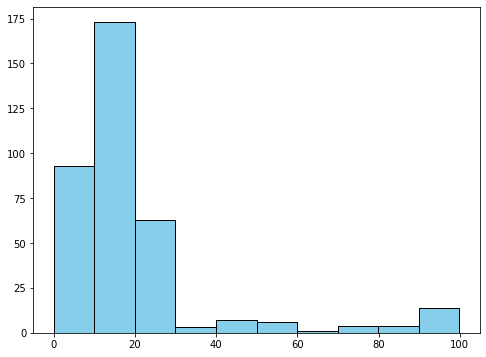

In [80]:
# Missing value distribution of mailout_train
mailout_train_missing_value = missing_value_check(mailout_train)
mailout_train_missing_value

,missing_values_count,missing_values_percentage
Unnamed: 0,0,0.000000
LNR,0,0.000000
AGER_TYP,18925,44.183223
AKT_DAT_KL,6889,16.083394
ALTER_HH,13231,30.889735
...,...,...
WOHNDAUER_2008,6889,16.083394
WOHNLAGE,7749,18.091191
ZABEOTYP,0,0.000000
ANREDE_KZ,0,0.000000


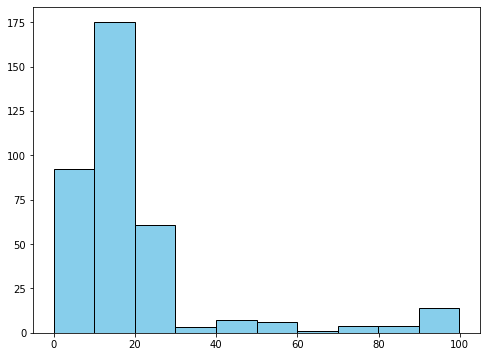

In [81]:
# Missing value distribution of mailout_test
mailout_test_missing_value = missing_value_check(mailout_test)
mailout_test_missing_value

In [82]:
# Based on above chart, most columns of mailout_train and mailout_test has missing value less than 30%
mailout_train_clean_column = mailout_train_missing_value[mailout_train_missing_value["missing_values_percentage"]<=30].index.tolist()
mailout_test_clean_column = mailout_test_missing_value[mailout_test_missing_value["missing_values_percentage"] <=30].index.tolist()

In [83]:
# Remove columns with missing value more than 30%
mailout_train_clean = mailout_train[mailout_train_clean_column]
mailout_test_clean = mailout_test[mailout_test_clean_column]

In [84]:
# Different column between mailout_train and mailout_test
diff = set(mailout_train_clean_column) - set(mailout_test_clean_column)
diff

{'RESPONSE'}

In [87]:
# Define function to impute missing value 
def impute_missing_value(dataframe):
    
    dataframe_column = dataframe.columns.tolist()
    dataframe_copy = dataframe.copy()

    for col in dataframe_column:
        
        dataframe_copy[col] = dataframe_copy[col].fillna(method='ffill')
        dataframe_copy[col].fillna(dataframe_copy[col].mode()[0], inplace=True) 
       
    dataframe = dataframe_copy

impute_missing_value(mailout_train_clean)
impute_missing_value(mailout_test_clean)

In [88]:
# Check if all missing value is imputed
has_na_train = mailout_train_clean.isna().any().any()
has_na_test = mailout_test_clean.isna().any().any()
print(has_na_train)
print(has_na_test)

False
False


In [92]:
X_train = mailout_train_clean.drop(columns = "RESPONSE", axis = 1)
y_train = mailout_train_clean["RESPONSE"]

In [93]:
# Random forest
rf_model = RandomForestClassifier()
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30]
}
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, return_train_score=False)
rf_grid_search.fit(X_train, y_train)
print(f"Best parameters for RandomForestClassifier: {rf_grid_search.best_params_}")
print(f"Best cross-validation score for RandomForestClassifier: {rf_grid_search.best_score_}\n")

Best parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 10}
Best cross-validation score for RandomForestClassifier: 0.987616967038911



In [94]:
# Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lr_model = LogisticRegression(max_iter=1000)
lr_params = {
    'C': [1, 5, 10]
}
lr_grid_search = GridSearchCV(lr_model, lr_params, cv=5, return_train_score=False)
lr_grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters for LogisticRegression: {lr_grid_search.best_params_}")
print(f"Best cross-validation score for LogisticRegression: {lr_grid_search.best_score_}\n")

Best parameters for LogisticRegression: {'C': 1}
Best cross-validation score for LogisticRegression: 0.987616967038911



In [95]:
# Gradient Boosting
gbc_model = GradientBoostingClassifier()
gbc_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}
gbc_grid_search = GridSearchCV(gbc_model, gbc_params, cv=5, return_train_score=False)
gbc_grid_search.fit(X_train, y_train)
print(f"Best parameters for GradientBoostingClassifier: {gbc_grid_search.best_params_}")
print(f"Best cross-validation score for GradientBoostingClassifier: {gbc_grid_search.best_score_}\n")

Best parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'n_estimators': 50}
Best cross-validation score for GradientBoostingClassifier: 0.987616967038911



In [96]:
# Predict using Logistic Regression model

X_test = mailout_test_clean
X_test_scaled = scaler.fit_transform(X_test)
y_pred = lr_grid_search.predict(X_test_scaled)